In [1]:
laptop = True

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

In [2]:
import os
import sys
from matplotlib.pyplot import *
from numpy import *
from tqdm.auto import tqdm
import itertools
import csv
import h5py
import matplotlib.gridspec as gds
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as pcs
import pickle
import pandas as pd
from scipy.io import loadmat
from scipy import interpolate

# Import diverse functions
from shared.functions import fit_gaussian, get_ellipse_parameters, plot_dendrogram
from shared.save_load import *

# For clustering
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# Load data

### Baden data

In [3]:
Folder = rootF + '/Documents/Myopia/Data analysis/calcium_comparison/'

# Baden data
baden = loadmat(Folder + 'baden_data.mat')
# Calcium transform data
calcium = loadmat(Folder + 'calcium_conversion.mat')

chirp_stim = baden['chirp_stim'][:,0]/max(baden['chirp_stim'][:,0]) # the stimulus
chirp_stim_time = baden['chirp_stim_time'][0,:] + 2   # the stimulus times, 2 seconds later than my stim
baden_time_original = baden['chirp_time'][0,:]   # 2 seconds later than my stim
group_idx = baden['group_idx'] 
psth_euler = baden['chirp_avg'] # the average calcium traces

# Baden types : load cell types names
euler_labels_f = open(Folder + 'Baden Types');
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1     
        
n_baden_types = len(euler_labels)

In [4]:
print ('Euler labels :', n_baden_types, 'types')
for i in euler_labels:
    print(i, euler_labels[i][0])

Euler labels : 32 types
0 OFF local OS
1 OFF DS
2 OFF step
3 OFF slow
4 OFF alpha sustained
5 ON-OFF JAM-B
6 OFF sustained
7 OFF alpha transient
8 OFF mini alpha transient
9 ON-OFF local-edge W3
10 ON-OFF local
11 ON-OFF DS 1
12 ON-OFF DS 2
13 ON-OFF local OS
14 ON step
15 ON DS transient
16 ON local transient OS
17 ON transient
18 ON transient large
19 ON high frequency
20 ON low frequency
21 ON sustained
22 ON mini alpha
23 ON alpha
24 ON DS sustained 1
25 ON DS sustained 2
26 ON slow
27 ON constrast suppression
28 ON DS sustained 3
29 ON local sustained OS
30 OFF suppression 1
31 OFF suppression 2


### Our chirp stimulation

In [5]:
# Get Euler stim profile

# def get_euler():
#     if laptop:
#         vec_path = 'E:/MEA data/exp19/STIMS/Euler/'
#     else:
#         vec_path = '/media/sarah/Sarah_1/MEA data/exp19/STIMS/Euler/'
#     vec_path = vec_path + r"euler.vec"
#     euler_vec = np.genfromtxt(vec_path)

#     return (euler_vec[150:1750,1]/max(euler_vec[150:1750,1])) #return in 100ms steps

# euler_vec = get_euler()

# Plot
# figure(figsize = (16,4))
time_stim = np.linspace(0,32,50*32+1)[:-1]
time = np.linspace(0,32,321)[:-1]
# # Our chirp
# plot(time_stim, euler_vec, label='our chirp')
# euler_vec.shape
# euler_vec[::5].shape,time.shape
# # Baden chirp
# plot(chirp_stim_time ,chirp_stim+1.5, label = 'Baden chirp')
# chirp_stim_time.shape, chirp_stim.shape
# legend(frameon=False)

# Comparison range:
comp_range = [0.1,31.9]         # to avoid prestep effects ### why 0.1 and not 2 ?
delta_range = comp_range[1]-comp_range[0]
time_common = np.linspace(comp_range[0],comp_range[1],int(delta_range/0.05) +2)

### Euler calcium data

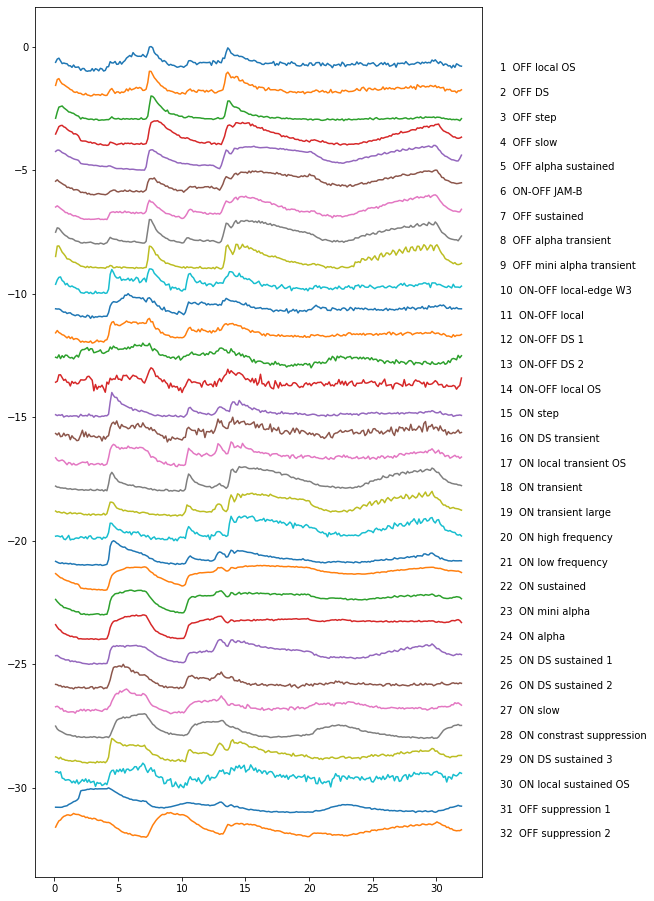

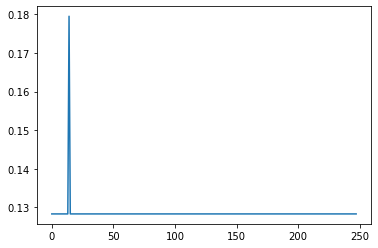

In [6]:
# Generate Baden type traces

# the two additional seconds at the end of Baden stim that will be stitched in the beginning
baden_time = baden_time_original+2
baden_first = baden_time[-15:]-32 
baden_time = np.append(baden_first,baden_time[:-15])

# we do the same for the calcium traces
Baden_types = []

figure(figsize=(8,16))

for i in np.arange(n_baden_types)+1:
    trace = np.mean(psth_euler[:,(group_idx==i)[:,0]],1)
    trace = trace-min(trace)
    trace = trace/max(trace)
    trace = np.append(trace[-15:],trace[:-15])                # I stitch las 2 s in the beggining so that it is 
                                                              #  the same as my experimental stim
    Baden_types.append(trace)
    plot(baden_time,trace-i)
    text(35,-i,str(i)+'  '+euler_labels[i-1][0])

figure()
plot(diff(baden_time))

### Clustering results

From Analyse_cell_type.ipynb

In [7]:
# experiment data
exp = 20211207
exp_path = rootF + '/Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'
clustering_data = exp_path + str(exp) + '_clustermodel'
model, psth_z = load_obj(clustering_data)

labels = model.labels_
exp_labels = np.sort(np.unique(labels))
psth_z.shape, 'Ncells  - Ndatapoints'

((112, 320), 'Ncells  - Ndatapoints')

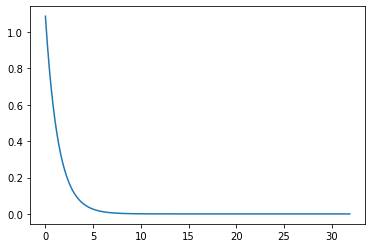

In [8]:
# functions for calcium traces

def calcium_exp(x):
    a =           0
    b =       1.086 
    c =       1.747 -1.0              ##################### changes here
    val = a+b*np.exp(-c*x)
    return val

def toCalciumLinear(time_sequence, spike_train):
    calcium_filter = calcium_exp(time_sequence);
    
    stitch3 = np.append(spike_train,[spike_train,spike_train])
    
    calcium_trace = np.convolve(stitch3, calcium_filter, 'full')[len(spike_train):len(spike_train)*2];
    calcium_trace = calcium_trace-min(calcium_trace)
    calcium_trace=calcium_trace/max(calcium_trace)
    return calcium_trace
    

calcium_filter = calcium_exp(time);
plot(time,calcium_filter)

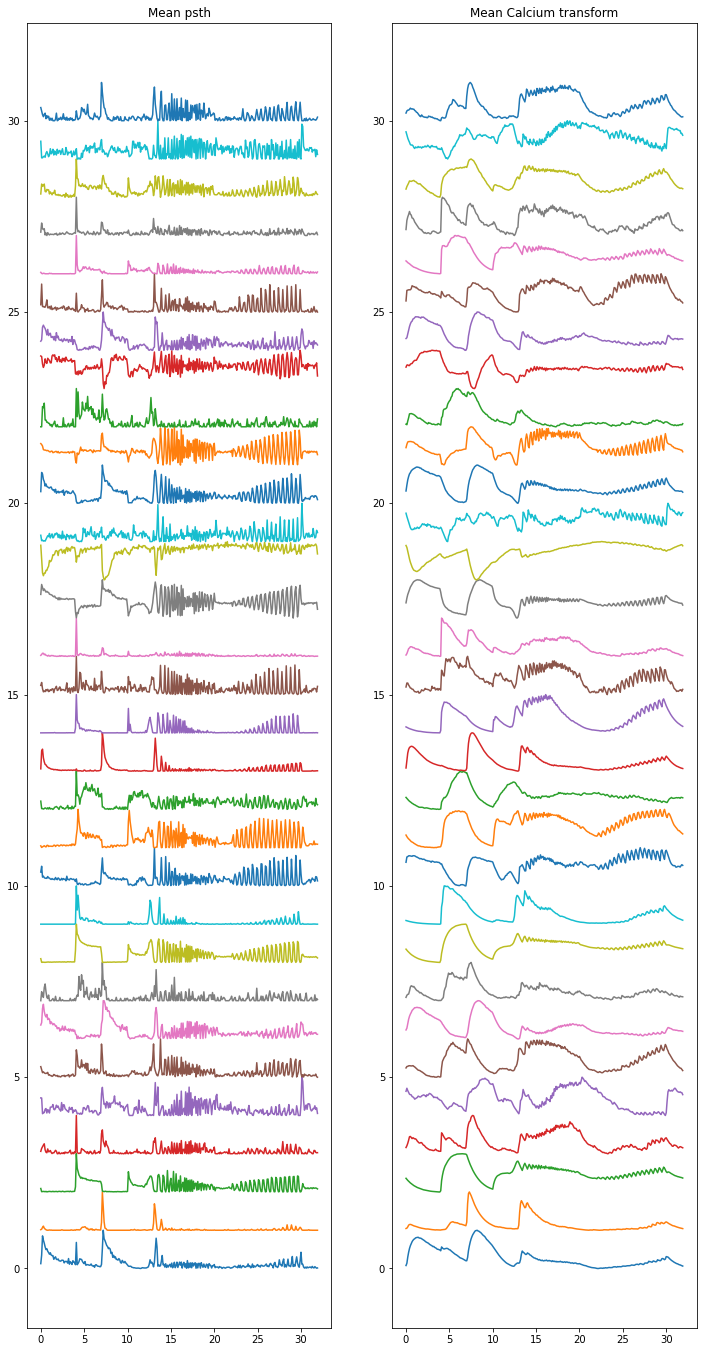

In [9]:
# Generate experiment type traces
Exp_types = []
fig = figure(figsize=(12,24))
fig.add_subplot(1,2,1)
for i in exp_labels:
    trace = np.mean(psth_z[(labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_types.append(trace)
    plot(time,trace+i)
    title('Mean psth')

# Experiment to calcium
Exp_types_Ca = {}
fig.add_subplot(1,2,2)
for i in exp_labels:
    trace = toCalciumLinear(time,Exp_types[i])
    Exp_types_Ca[i] = trace
    plot(time,trace+i)
    title('Mean Calcium transform')

# Correlate groups

In [10]:
# Interpolate calcium traces (Baden and transformed traces)
Baden_common = {}
for i in np.arange(n_baden_types):
    f = interpolate.interp1d(baden_time, Baden_types[i])
    Baden_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

Exp_common={}
for i in exp_labels:
    f = interpolate.interp1d(time, Exp_types_Ca[i])
    Exp_common[i] = f(time_common)   # use interpolation function returned by `interp1d`

n_matches = 29
corr_table = np.zeros([len(exp_labels),n_baden_types]) 
corr_match = np.zeros([len(exp_labels),n_baden_types])
corr_match_vals = np.zeros([len(exp_labels),n_baden_types])
delta_match = np.zeros([len(exp_labels),n_baden_types+1])

# For each of our generated calcium type we compute the corr coef with each Baden type
for i in exp_labels:
    for j in np.arange(n_baden_types):
        corr_table[i,j] = np.corrcoef(Exp_common[i], Baden_common[j])[0,1]
    # For each calcium type, sort de corr coefs in descending order (max first)
    corr_match[i,:] = np.flip(np.argsort(corr_table[i,:])[-32:]) # sorted indices
    corr_match_vals[i,:] = corr_table[i,:][np.flip([np.argsort(corr_table[i,:])[-32:]])] # sorted corr coef values
    # Select the 10 larger corr coefs and store the difference with the next one
    for j in np.arange(10):
        delta_match[i,j] = corr_match_vals[i,j]-corr_match_vals[i,j+1]  

['OFF suppression 1']


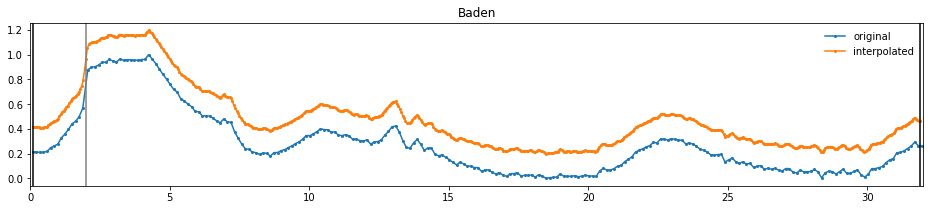

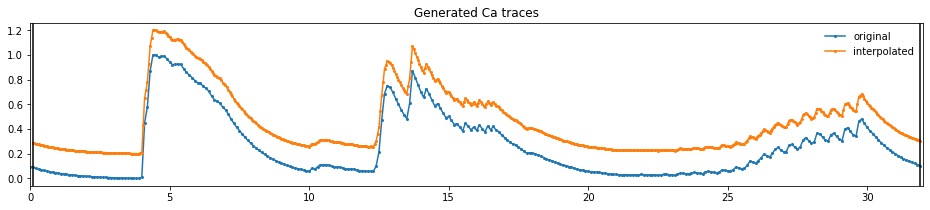

In [11]:
# Compare original and interpolated traces

# Baden traces
figure(figsize=(16,3))
idx = 30
title('Baden')
plot(baden_time, Baden_types[idx], '-o', ms=2, label = 'original')
plot(time_common, Baden_common[idx]+0.2, 'o-', ms=2, label = 'interpolated')
axvline(comp_range[0],color='k')
axvline(comp_range[1],color='k')
axvline(2,color='gray')
xlim([0,32])
legend(frameon=False)
print(euler_labels[idx])

# Generated calcium traces
figure(figsize=(16,3))
idx = 9
title('Generated Ca traces')
plot(time, Exp_types_Ca[idx], '-o', ms=2, label='original')
plot(time_common, Exp_common[idx]+0.2, 'o-', ms=2, label='interpolated')
axvline(comp_range[0],color='k')
axvline(comp_range[1],color='k')
xlim([0,32])    
legend(frameon=False)


(array([0.84317042, 0.85122974, 0.85210354, 0.85282259, 0.86167394,
        0.86468697, 0.87050934, 0.88959514, 0.89756642, 0.92058623]),
 0.7633284860105815,
 0.7184433601208631)

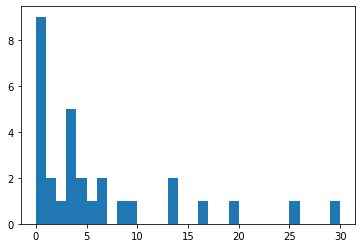

In [12]:
# Histogram of the difference between the first and second corr coef, for all cells
hist(delta_match[:,0]*100, bins=linspace(0,30,31))

np.sort(corr_match_vals[:,0])[-10:], np.median(corr_match_vals[:,0]), np.mean(corr_match_vals[:,0])

(array([1., 5., 1., 1., 2., 0., 1., 2., 0., 0., 0., 1., 0., 1., 0., 2., 1.,
        0., 0., 0., 1., 1., 0., 2., 0., 0., 1., 3., 2., 1., 1., 0.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 <BarContainer object of 32 artists>)

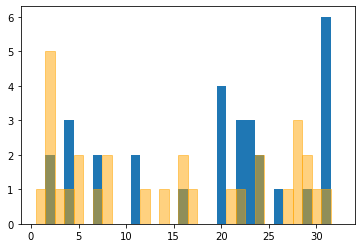

In [13]:
# Histo of the indices of first and second largest corr coefs
hist(corr_match[:,0], bins=np.arange(33)+0.5)
hist(corr_match[:,1], bins=np.arange(33)+0.5,fc='orange',ec='orange',alpha=0.5)

# Manual selection of Groups

In [14]:
fsave = exp_path + 'cells_characterization_data_with_cluster_type' + str(exp) 
cell_data = load_obj(fsave)

fsave = exp_path + str(exp) + '_selected_cells_clustering'
selected_cells = np.array(load_obj(fsave))

match 2   10 Baden  3
match 0   10 Baden  4
match 4   10 Baden  5
match 3   10 Baden  7
match 1   10 Baden  8


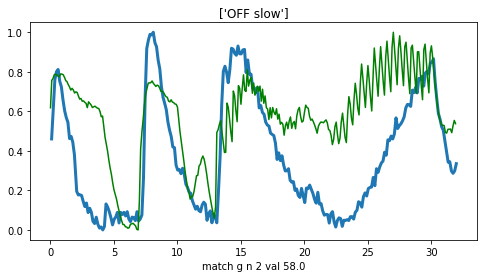

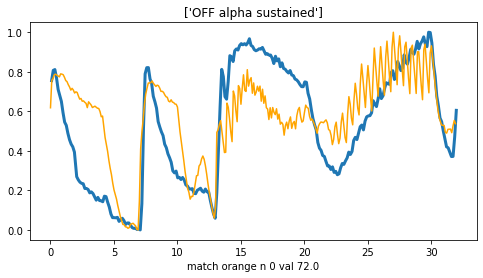

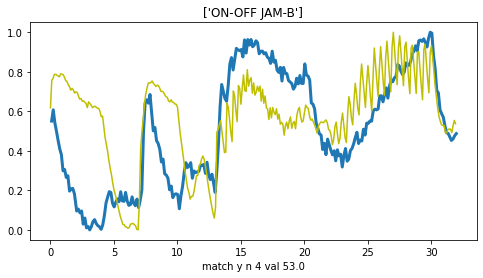

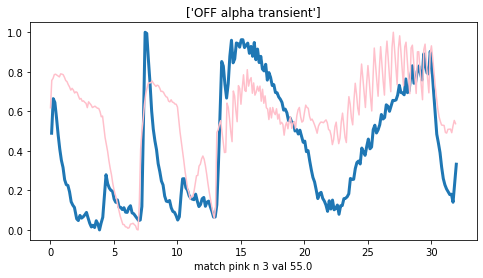

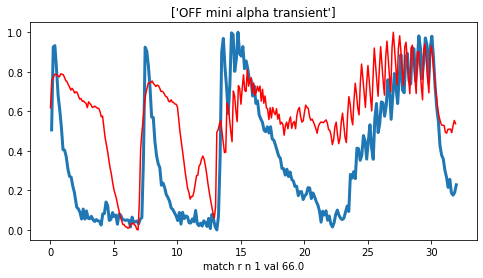

In [15]:
sel_badens = np.arange(32)

# The generated calcium trace we look at
sel_cells = [10]

n_match_sel = 5 # number of best matching Baden traces we look at for manual selection

colors = ['orange','r','g','pink','y','gray','k','c','m','darkgray','coral','gold','plum','wheat','navy']
#             0     1   2    3     4    5     6   7   8      9         10      11     12      13     14

# For each generated calcium trace we look at the first 5 best matching Baden traces
for i in sel_badens:
    Plot = False
    for j in sel_cells:
        for n_match in np.arange(n_match_sel):
            if corr_match[j, n_match]==i:
                if not(Plot): 
                    figure(figsize=(8,4))
                    plot(baden_time, Baden_types[i],lw=3)
                    title(euler_labels[i])
                    Plot=True
                if Plot:
                    plot(time, Exp_types_Ca[j],color=colors[n_match%15])
                    xlabel('match '+colors[n_match%15]+' n ' +str(n_match)+' val '+str(np.round(corr_match_vals[j,n_match]*100)) )
                    print('match', str(n_match),' ', j, 'Baden ',i)
                    
# Manually selected Baden types
manual_selection = corr_match[:,0].astype('int')

### NEW 7/4/2023
# indices are cluster groupe number, n match
manual_selection[0] = corr_match[0,0] # OFF supp 2
manual_selection[1] = corr_match[1,1] # OFF DS
manual_selection[2] = corr_match[2,0] # ON mini alpha
manual_selection[3] = corr_match[3,30] # ON OFF DS 2 (OFF alpha transient)
manual_selection[4] = corr_match[4,5] # OFF suppression 1
manual_selection[5] = corr_match[5,1] # ON local sustained OS
manual_selection[6] = corr_match[6,0] # OFF supp 2
manual_selection[7] = corr_match[7,0] # ON OFF DS 1
manual_selection[8] = corr_match[8,7] # ON alpha
manual_selection[9] = corr_match[9,1] # ON DS susatined 3
manual_selection[10] = corr_match[10,2] # OFF slow
manual_selection[11] = corr_match[11,1] # OFF DS sustained 1
manual_selection[12] = corr_match[12,0] # ON slow 
manual_selection[13] = corr_match[13,4] # OFF mini alpha transient
manual_selection[14] = corr_match[14,1] # ON transient
manual_selection[15] = corr_match[15,5] # ON DS transient 
manual_selection[16] = corr_match[16,0] # ON low frequency
manual_selection[17] = corr_match[17,11] # OFF sustained
manual_selection[18] = corr_match[18,3] # ON transient large
manual_selection[19] = corr_match[19,6] # OFF sustained
manual_selection[20] = corr_match[20,4] # OFF alpha sustained
manual_selection[21] = corr_match[21,2] # ON OFF JAM B
manual_selection[22] = corr_match[22,4] # ON OFF local
manual_selection[23] = corr_match[23,0] #
manual_selection[24] = corr_match[24,0] # OFF supp 2
manual_selection[25] = corr_match[25,2] # OFF alpha transient
manual_selection[26] = corr_match[26,0] # ON local transient OS
manual_selection[27] = corr_match[27,5] # ON OFF local wedge
manual_selection[28] = corr_match[28,0] # ON local sustained OS
manual_selection[29] = corr_match[29,18] # OFF sustained 
manual_selection[30] = corr_match[30,0] # OFF alpha transient

# # indices are cluster groupe number, n match
# manual_selection[0] = corr_match[0,7] # OFF DS
# manual_selection[1] = corr_match[1,0] # OFF local OS
# manual_selection[2] = corr_match[2,0] # ON mini alpha
# manual_selection[3] = corr_match[3,0] # OFF alpha transient
# manual_selection[4] = corr_match[4,5] # OFF suppression 1
# manual_selection[5] = corr_match[5,1] # ON local sustained OS
# manual_selection[6] = corr_match[6,0] # OFF suppression 2
# manual_selection[7] = corr_match[7,0] # ON OFF DS 1
# manual_selection[8] = corr_match[8,7] # ON alpha
# manual_selection[9] = corr_match[9,1] # ON DS susatined 3
# manual_selection[10] = corr_match[10,2] # OFF slow
# manual_selection[11] = corr_match[11,1] # OFF DS sustained 1
# manual_selection[12] = corr_match[12,0] # ON slow 
# manual_selection[13] = corr_match[13,0] # OFF step
# manual_selection[14] = corr_match[14,1] # ON transient
# manual_selection[15] = corr_match[15,5] # ON DS transient 
# manual_selection[16] = corr_match[16,0] # ON low frequency
# manual_selection[17] = corr_match[17,11] # OFF sustained
# manual_selection[18] = corr_match[18,3] # ON transient large
# manual_selection[19] = corr_match[19,6] # OFF sustained
# manual_selection[20] = corr_match[20,4] # OFF alpha sustained
# manual_selection[21] = corr_match[21,2] # ON OFF JAM B
# manual_selection[22] = corr_match[22,4] # ON OFF local
# manual_selection[23] = corr_match[23,0] #
# manual_selection[24] = corr_match[24,0] # OFF suppression 2
# manual_selection[25] = corr_match[25,1] # OFF mini alpha transient
# manual_selection[26] = corr_match[26,0] # ON local transient OS
# manual_selection[27] = corr_match[27,2] # OFF alpha transient
# manual_selection[28] = corr_match[28,9] # ON sustained
# manual_selection[29] = corr_match[29,18] # OFF sustained 
# manual_selection[30] = corr_match[30,5] # ON high frequency

man_vals= np.zeros(len(exp_labels))
for i in exp_labels:
    if manual_selection[i]!=-1:
        match = np.where(manual_selection[i]==corr_match[i,:])[0][0]
        man_vals[i] = corr_match_vals[i,match]

Group 1    Baden  1 ['OFF DS']


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

Group 10    Baden  3 ['OFF slow']
Group 20    Baden  4 ['OFF alpha sustained']
Group 21    Baden  5 ['ON-OFF JAM-B']


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

Group 17    Baden  6 ['OFF sustained']
Group 19    Baden  6 ['OFF sustained']
Group 29    Baden  6 ['OFF sustained']
Group 25    Baden  7 ['OFF alpha transient']
Group 30    Baden  7 ['OFF alpha transient']
Group 13    Baden  8 ['OFF mini alpha transient']
Group 27    Baden  9 ['ON-OFF local-edge W3']
Group 22    Baden  10 ['ON-OFF local']
Group 7    Baden  11 ['ON-OFF DS 1']
Group 3    Baden  12 ['ON-OFF DS 2']
Group 15    Baden  15 ['ON DS transient']
Group 26    Baden  16 ['ON local transient OS']
Group 14    Baden  17 ['ON transient']
Group 18    Baden  18 ['ON transient large']


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

Group 16    Baden  20 ['ON low frequency']


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

Group 2    Baden  22 ['ON mini alpha']


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

Group 8    Baden  23 ['ON alpha']


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

Group 11    Baden  24 ['ON DS sustained 1']
Group 12    Baden  26 ['ON slow']
Group 9    Baden  28 ['ON DS sustained 3']


C:\Users\goethas\AppData\Local\Temp/ipykernel_17000/1902730282.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=figure(figsize=(16,5))
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta))

Group 5    Baden  29 ['ON local sustained OS']
Group 28    Baden  29 ['ON local sustained OS']
Group 4    Baden  30 ['OFF suppression 1']


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

Group 0    Baden  31 ['OFF suppression 2']
Group 6    Baden  31 ['OFF suppression 2']
Group 23    Baden  31 ['OFF suppression 2']
Group 24    Baden  31 ['OFF suppression 2']
counts 24


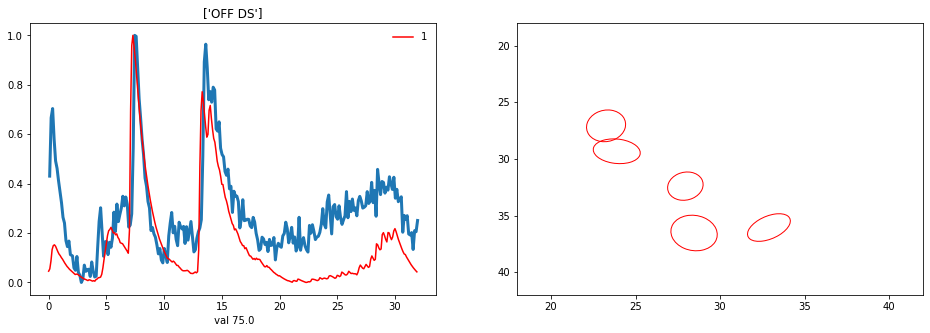

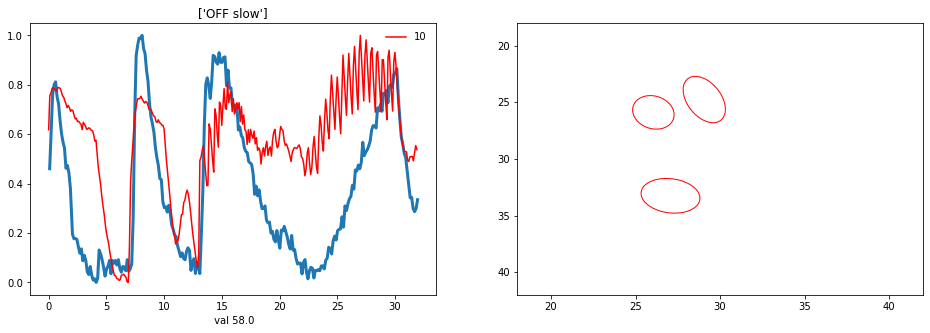

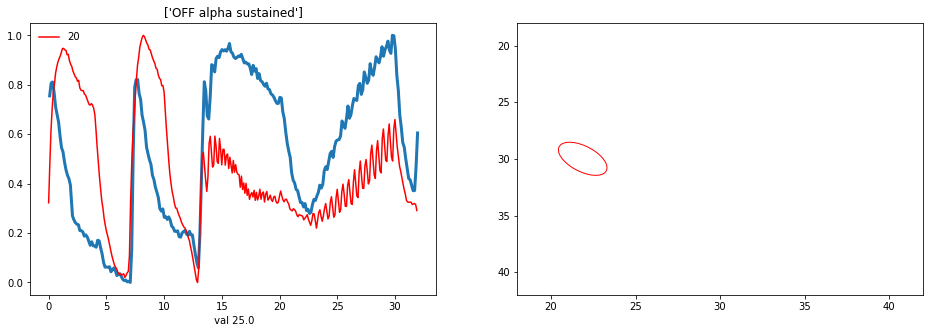

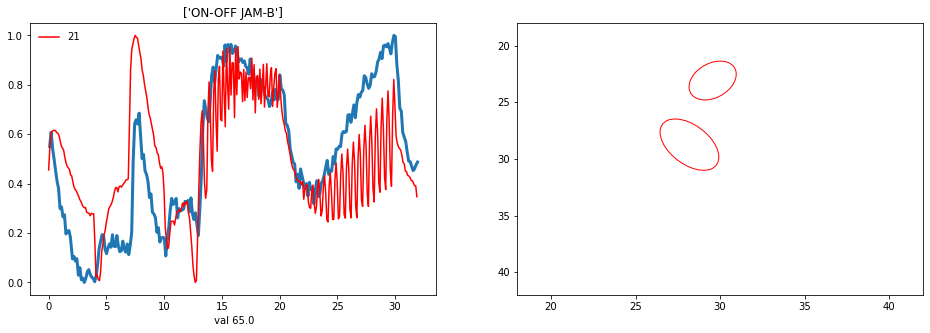

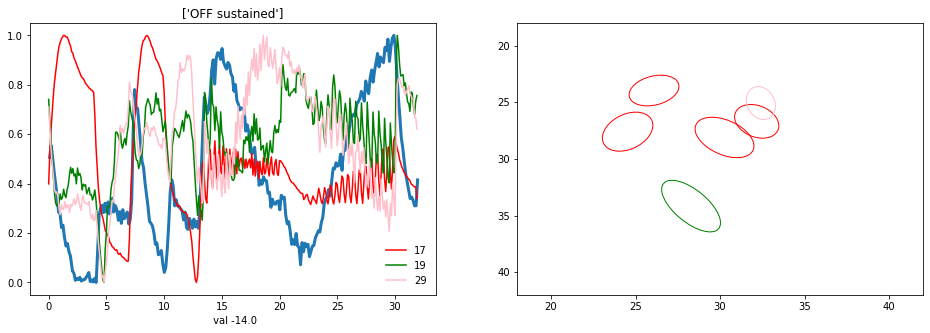

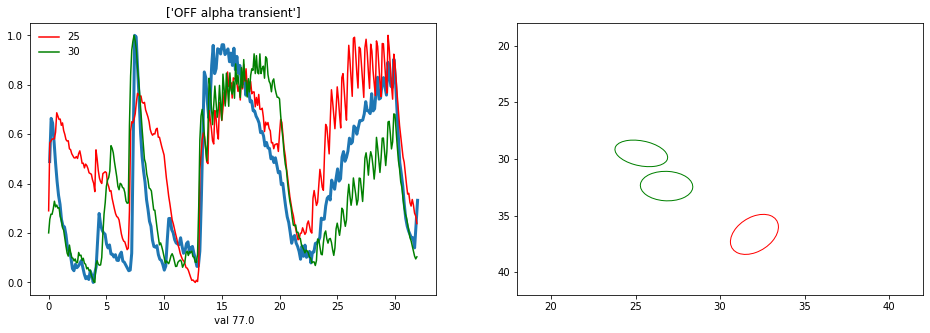

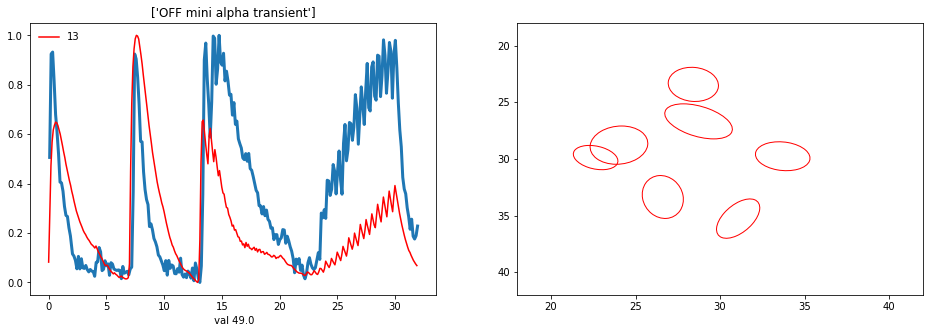

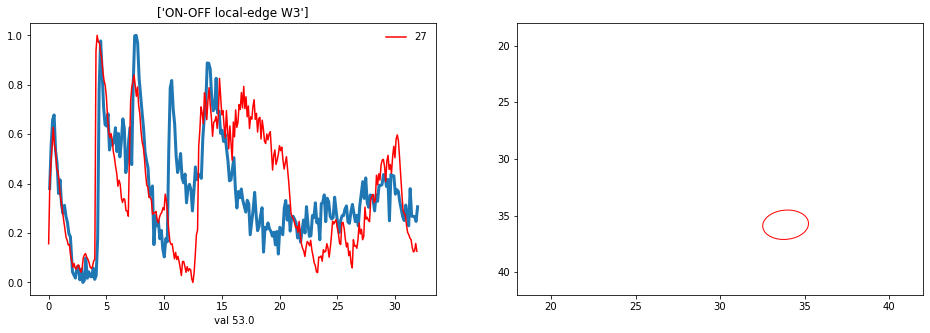

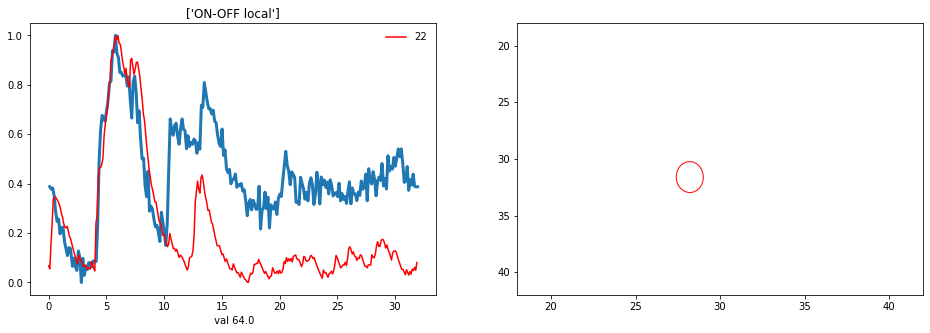

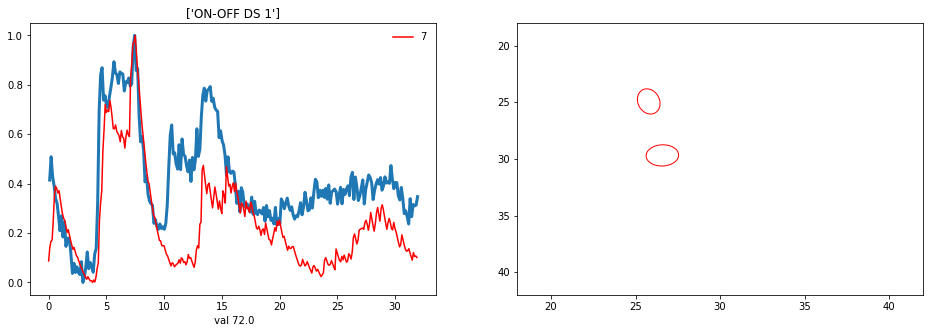

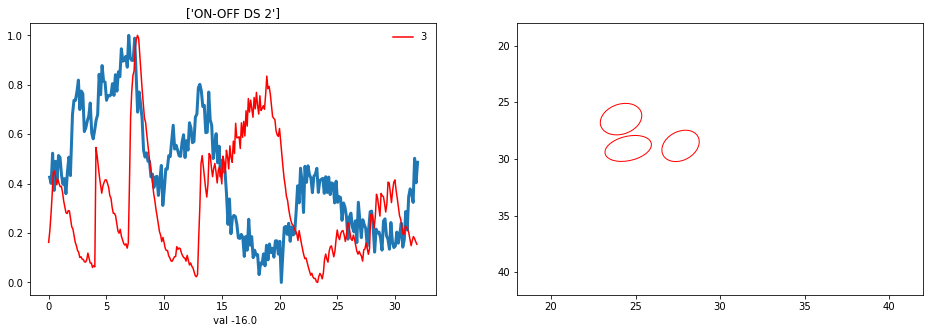

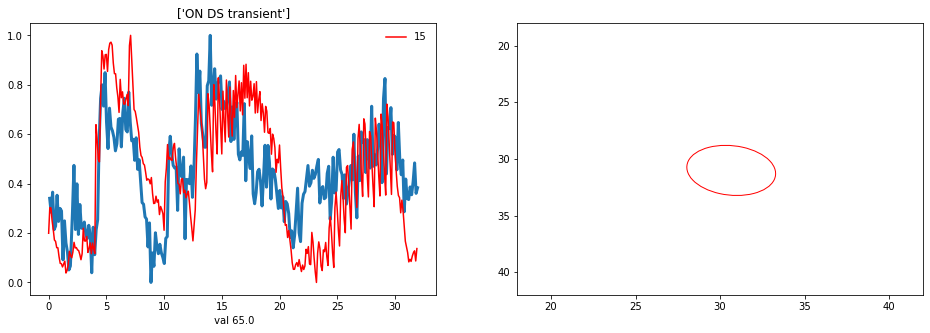

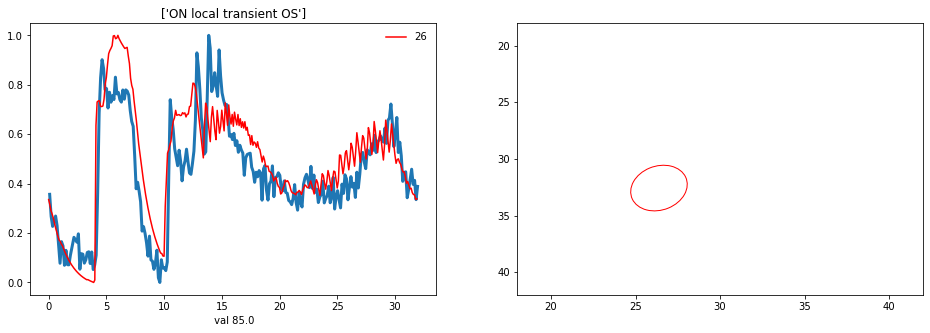

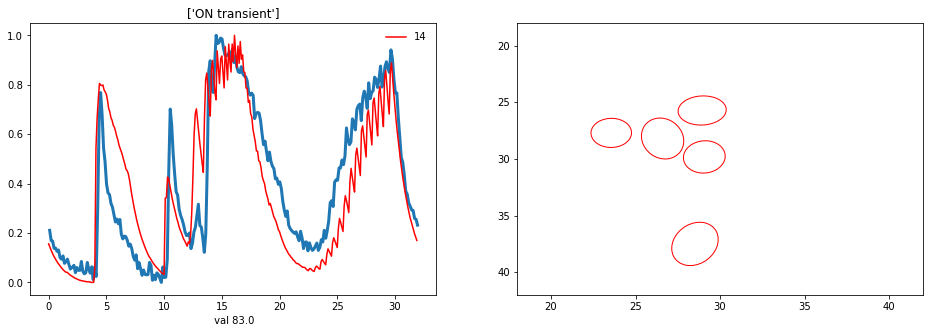

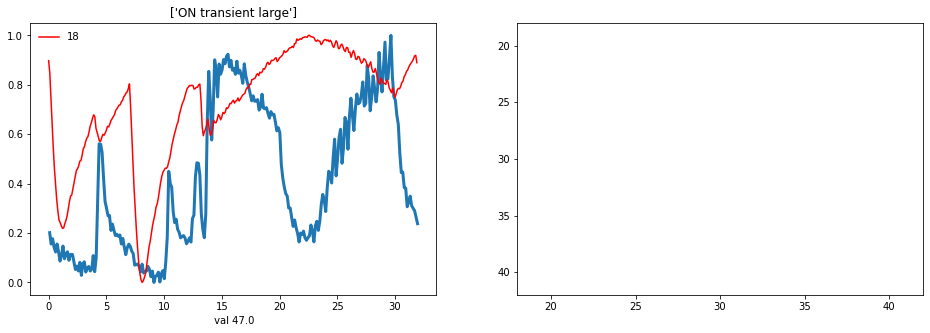

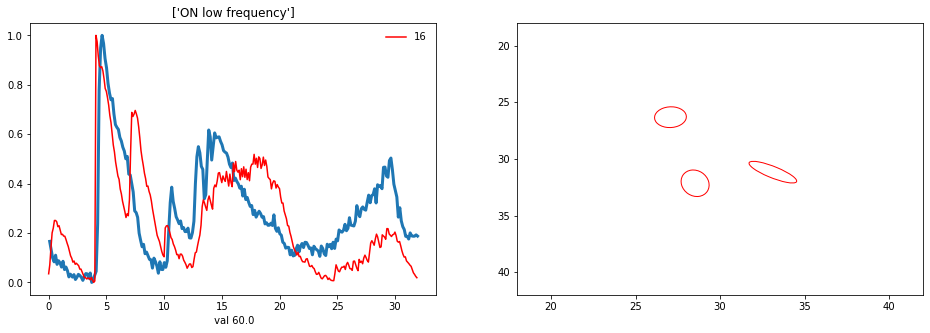

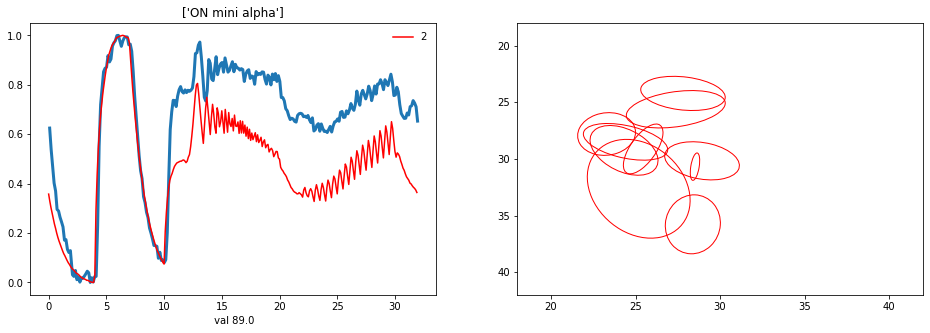

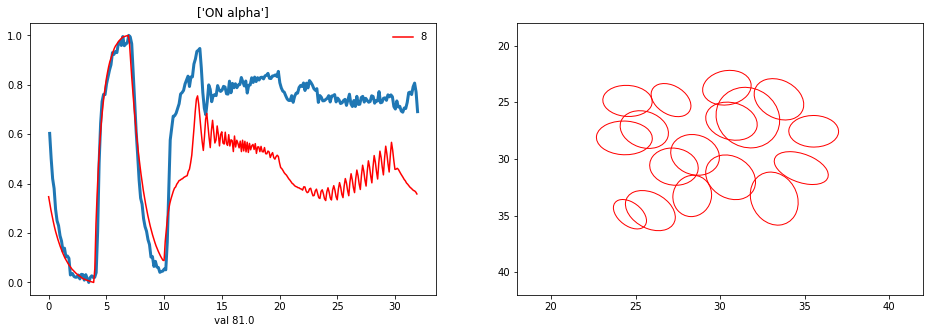

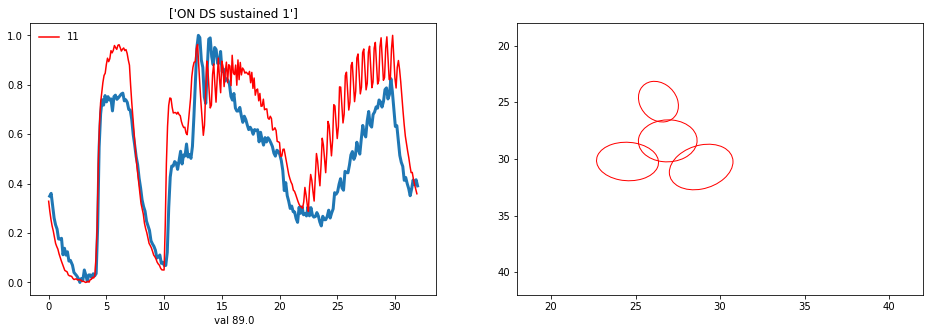

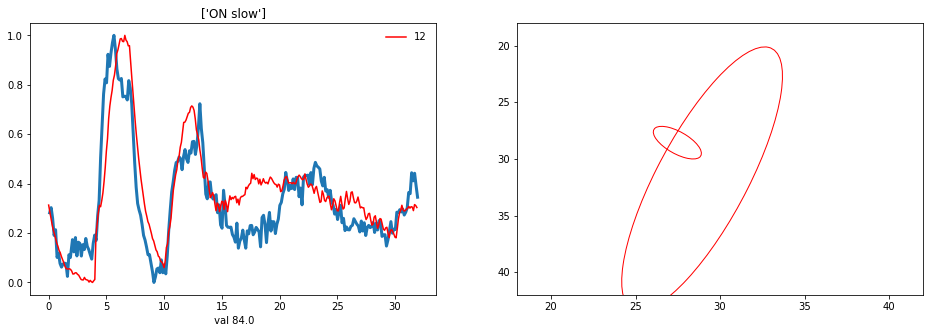

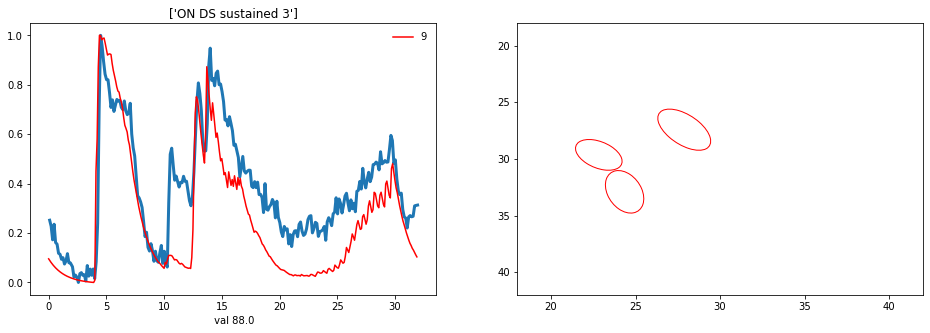

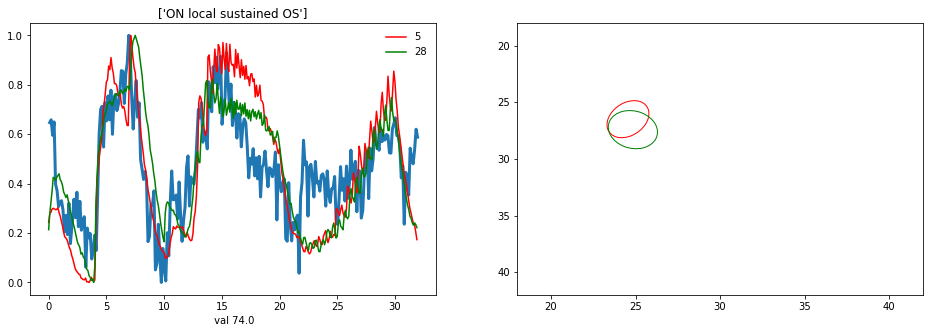

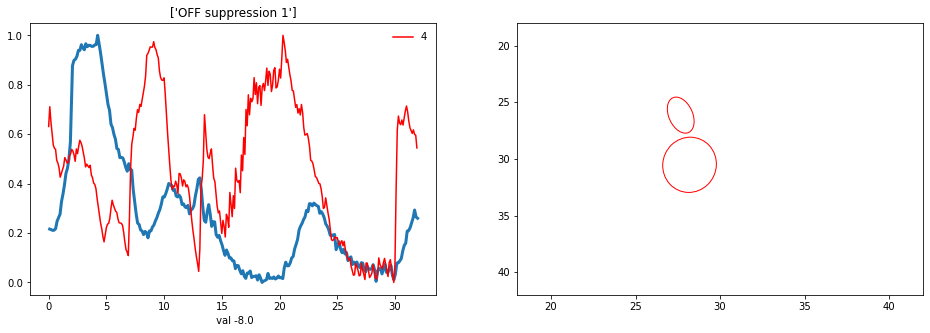

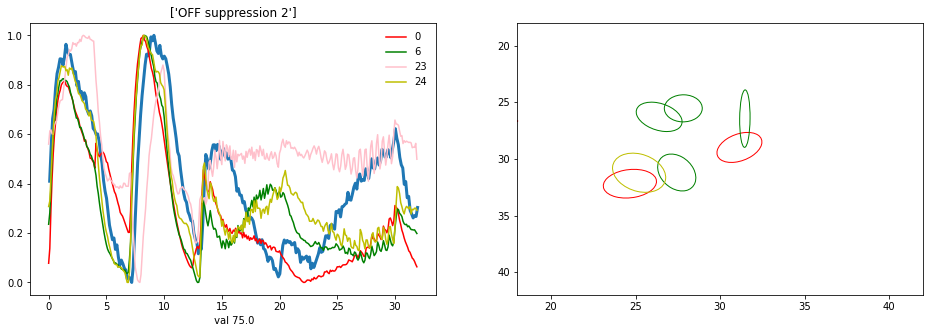

In [25]:
# Here plot the final groups

sel_badens = np.arange(32)
sel_exps = exp_labels

sel_cells = np.arange(31)

countg=0
for i in sel_badens:
    cc=0
    Plot=False
    for j in sel_cells:

        if manual_selection[j]==i:
            if not(Plot): 
                fig=figure(figsize=(16,5))
                ax1 = fig.add_subplot(1,2,1)
                ax2 = fig.add_subplot(1,2,2)
                ax1.plot(baden_time, Baden_types[i],lw=3)
                ax1.set_title(euler_labels[i])
                Plot=True
                countg+=1
            if Plot:
                
                ax1.plot(time, Exp_types_Ca[j], label = str(j), color=colors[cc+1])
                ax1.set_xlabel(' val '+str(np.round(man_vals[j]*100)) )#+ euler_labels[i][1])
                ax1.legend(frameon=False)
                
                clustersin = selected_cells[np.where((model.labels_==j))[0]]
                cc+=1
                for c in clustersin:
                    x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[c]["spatial_sta"])
                    x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
                    xy = (x0, y0)
                    ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color = colors[cc],lw=1)
                    ax2.add_patch(ellipse)
#                     ax2.plot(cell_data[c]['ellipseMat'][0]   , cell_data[c]['ellipseMat'][1] ,color=colors[cc] ,lw=0.5)#,lw=10)    #rotated ellipse
                ax2.set_xlim(18,42)
                ax2.set_ylim(42,18)

                    
                print('Group',j, '   Baden ',i, euler_labels[i])
print('counts' ,countg)

### New cluster labels

In [26]:
new_labels = np.zeros(len(model.labels_))
for j in np.arange(len(model.labels_)):
    new_labels[j] = manual_selection[model.labels_[j]]

# here assign label to each cluster
Dic_labels={}
for i in np.arange(len(new_labels)):
    if new_labels[i]!=-1:
        Dic_labels.update({list(selected_cells)[i]: euler_labels[new_labels[i]]})
#--------------------
for c in sorted(list(Dic_labels.keys())):
     print('Clus ',c, '   Baden ',Dic_labels[c])

Clus  6    Baden  ['OFF suppression 2']
Clus  26    Baden  ['OFF alpha sustained']
Clus  33    Baden  ['ON DS transient']
Clus  41    Baden  ['ON DS sustained 1']
Clus  44    Baden  ['ON-OFF local']
Clus  45    Baden  ['ON DS sustained 1']
Clus  52    Baden  ['ON local sustained OS']
Clus  59    Baden  ['OFF suppression 2']
Clus  60    Baden  ['ON low frequency']
Clus  61    Baden  ['OFF suppression 2']
Clus  63    Baden  ['OFF DS']
Clus  64    Baden  ['ON low frequency']
Clus  65    Baden  ['OFF suppression 1']
Clus  69    Baden  ['OFF alpha transient']
Clus  77    Baden  ['ON alpha']
Clus  85    Baden  ['OFF suppression 2']
Clus  89    Baden  ['ON transient']
Clus  95    Baden  ['ON transient']
Clus  98    Baden  ['ON transient']
Clus  100    Baden  ['ON-OFF DS 1']
Clus  103    Baden  ['ON mini alpha']
Clus  107    Baden  ['ON transient']
Clus  110    Baden  ['ON mini alpha']
Clus  114    Baden  ['OFF DS']
Clus  120    Baden  ['OFF DS']
Clus  129    Baden  ['ON alpha']
Clus  141    B

C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\goethas\Anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\goethas\Anaconda3\lib\site-package

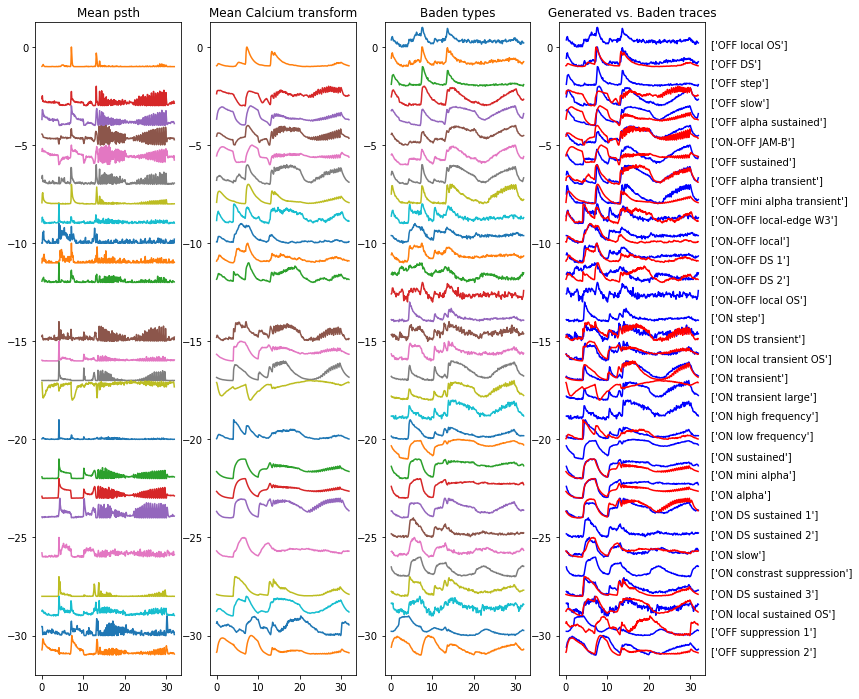

In [27]:
# Generate new experiment type traces
Exp_sorted_types = []

fig = figure(figsize=(12,12))

# Average MEA traces 
fig.add_subplot(1,4,1)
for i in euler_labels.keys():
    trace = np.mean(psth_z[(new_labels==i),:],0)
    trace = trace-min(trace)
    trace = trace/max(trace)
    Exp_sorted_types.append(trace)
    plot(time,trace-i)
    title('Mean psth')
    ylim([-32,1.25])
    
# Experiment to calcium
Exp_sorted_types_Ca = {}
fig.add_subplot(1,4,2)
for i in euler_labels.keys():
    trace = toCalciumLinear(time,Exp_sorted_types[i])
    Exp_sorted_types_Ca[i] = trace
    plot(time,trace-i)
    title('Mean Calcium transform')
    ylim([-32,1.25])
    
# Baden calcium traces
fig.add_subplot(1,4,3)
for i in euler_labels.keys():
    plot(baden_time,Baden_types[i]-i)
    ylim([-32,1.25])
    title('Baden types')

# Comparison
fig.add_subplot(1,4,4)
for i in euler_labels.keys():
    plot(baden_time,Baden_types[i]-i,'b')
    plot(time,Exp_sorted_types_Ca[i]-i,'r')
    text(35,-i,euler_labels[i])
    ylim([-32,1.25])
    title('Generated vs. Baden traces')

# Create a summary figure for each cluster type

In [28]:
for icluster in range(len(euler_labels))[0:]:
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))
    
    if len(idx_cluster) > 0:

        gs = gds.GridSpec(len(idx_cluster)+2,9)

        if len(idx_cluster)<7:
            yspan = 2
        else:
            yspan=-2
        fig=figure(figsize=(20,(len(idx_cluster)+yspan)*1.75))
        plt.suptitle("Cell group {}   {}   {} cells".format(icluster,euler_labels[icluster], len(idx_cluster)),size=24)

        # Loop cells in cluster
        line = 1
        STAs=np.zeros(40)
        STAcount=0
        waves=np.zeros(101)
        wavecount=0
        
        for index in sorted(idx_cluster):
            cell_nb = list(selected_cells)[index]

            # Plot temp STA
            ax= subplot(gs[line+1,1])
            ax.set_ylim([-1,1])
            ax.axis("off")
            ax.set_aspect(0.75)
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
            polarity = cell_data[cell_nb]["polarity"]
            ax.set_title('Cluster ' + str(cell_nb) + '  Polarity '+polarity)
            ax.axhline(0,color='k',lw=0.5)

            STAs+=cell_data[cell_nb]["temporal_sta"]
            STAcount+=1

            # Plot temp STA avg
            ax= subplot(gs[0,1])
            ax.set_title('Temp STA')
            ax.set_ylim([-1,1])
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_xlabel('Time(s)')
            ax.axis("off")
            ax.set_aspect(0.75)

            # plot Spatial STA
            ax= subplot(gs[line+1,0])
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
            ax.set_xlim(16,44)
            ax.set_ylim(44,16)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])

            #plot waveform
            ax= subplot(gs[line+1,2])
            wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
            ax.plot(wave,'r')
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            waves+=wave
            wavecount+=1

            ax= subplot(gs[0,2])
            ax.plot(wave,lw=0.5)
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])

            # plot Euler PSTH
            ax= subplot(gs[line+1,3:6])
            cell_index=list(selected_cells).index(cell_nb)
            ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if line+1 == len(idx_cluster)+2:
                ax.set_xlabel('Time (s)')
            else:
                ax.set_xticks([])
            plt.locator_params(axis="y", nbins=3)
            
            # plot Euler rasters
            ax = subplot(gs[line+1,6:])
            euler_rasters = cell_data[cell_nb]["spike_trains"]
            ax.eventplot(euler_rasters)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_yticks([])
            ax.set_xlim(0,32)
            if line+1 == len(idx_cluster)+2:
                ax.set_xlabel('Time (s)')
            else:
                ax.set_xticks([])

            # plot Ellipse
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])

            x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
            xy = (x0, y0)

            ax= subplot(gs[line+1,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
            ax.add_patch(ellipse)

            ax= subplot(gs[0:1,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
            ax.add_patch(ellipse)

            line+=1

        # avg STA
        STAs=STAs/STAcount
        ax= subplot(gs[0,1])
        ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
        ax.set_ylim([-1,1])
        ax.set_aspect(0.75)
        ax.axis("off")

        # avg wave
        waves=waves/wavecount
        ax= subplot(gs[0,2])
        ax.set_title('Waveform')
        ax.plot(waves,'r',lw=2)
        ax.set_ylim([-1.25,1.25])
        #ax.set_aspect(0.075)
        ax.axis("off")

        # size ellipses
        ax= subplot(gs[0:1,0])
        ax.set_title('Ellipses')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        # mean psth
        ax= subplot(gs[0,3:6])
        ax.set_title('Euler psth')
        ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
        ax.axis("off")

        # mean Ca trace + comparison
        ax= subplot(gs[1,3:6])
        ax.set_title('Calcium traces')
        ax.axis("off")

        plot(time,Exp_sorted_types_Ca[icluster] ,'g')
        plot(baden_time,Baden_types[icluster],'r')

        # plot euler stim
        euler_vec= get_euler()
        ax= subplot(gs[0,6:])
        ax.plot(time_stim,euler_vec, color='k')
        ax.set_ylim([-0.25,1.25])
        ax.set_xlim(0,32)
        ax.set_xlabel('Time(s)')
        ax.axis("off")
        ax.set_title('Chirp stimulus profile')
        
        ### Save figure

        PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/Baden types/'
        fsave = PDF_folder +'exp'+ str(exp) +'_badentype' +str(icluster) 

        fig.savefig(fsave+'.png',format='png',dpi=250)
        close(fig)  


0
5
0
4


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

2
2
8


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

3
7
1
1
2
3
0
0
4
2
5
1
0
4


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

0
12


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

18


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

6


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

0
2
0
3
3


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

2
12


C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:305: RuntimeWarning: invalid value encountered in double_scalars
  a = + (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:306: RuntimeWarning: invalid value encountered in double_scalars
  b = - (np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.py:307: RuntimeWarning: invalid value encountered in double_scalars
  c = + (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
C:\Users\goethas\Documents\GitHub\Retina_clusters_analysis\shared\functions.p

# SAVE DATA

In [29]:
# Save average Ca traces for each type
fsave = exp_path + str(exp) + '_celltype_Ca_traces'
save_obj(Exp_sorted_types_Ca,fsave)

# Save Baden type for each cell in 'selected_cells'
fsave = exp_path + str(exp) + '_celltype_Baden'
save_obj(new_labels,fsave)

# Add blur data

## Load data

In [25]:
from shared.parameters_stimulation2 import *

if laptop:
    rootF = 'C:/Users/goethas/'
else:
    rootF = '/home/sarah/'

data_path = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/'

blur_data = load(data_path + str(exp) + '_selected_cells_spike_count_with_noise_NEW.npz')
    
spike_counts = blur_data['spike_count']
spike_counts_mean = blur_data['spike_count_mean']
spike_counts_std = blur_data['spike_count_std']
blur_clusters = blur_data['clusters']

Ncells = len(blur_clusters)

print (shape(spike_counts))
print (blur_clusters)

(150, 4, 2, 9, 4, 25)
[  5   7  10  20  22  41  45  52  55  56  62  63  66  73  78  83  86  90
  99 100 102 108 112 119 125 126 130 136 138 144 146 153 158 162 168 193
 195 210 220 236 238 241 247 253 260 263 270 271 273 276 280 283 284 285
 287 288 292 296 300 305 313 316 318 329 333 335 352 353 354 355 356 357
 359 360 361 368 370 380 382 387 389 401 404 406 407 411 412 415 416 417
 419 420 421 422 423 424 430 435 438 439 440 441 446 447 448 449 450 452
 457 460 463 464 466 467 468 469 470 471 472 478 479 480 482 486 492 493
 495 496 497 498 506 507 511 513 515 525 527 529 532 537 544 546 575 576
 580 592 597 605 611 613]


In [26]:
selected_cells

array([  5,  10,  20,  22,  41,  45,  55,  56,  62,  63,  66,  73,  78,
        83,  86,  99, 100, 102, 112, 119, 125, 126, 130, 136, 138, 144,
       153, 158, 162, 168, 195, 210, 220, 238, 241, 247, 260, 263, 270,
       271, 273, 276, 280, 283, 284, 287, 292, 296, 300, 316, 318, 329,
       333, 335, 356, 359, 360, 361, 368, 370, 380, 382, 387, 389, 401,
       406, 407, 411, 415, 419, 420, 421, 422, 424, 430, 435, 438, 439,
       441, 447, 449, 450, 452, 457, 460, 463, 464, 466, 469, 470, 471,
       472, 478, 480, 482, 486, 493, 496, 497, 498, 506, 511, 513, 515,
       529, 532, 544, 546, 576, 580, 592, 605, 613], dtype=int64)

In [27]:
pup = 0

cols = ['C0','C1','C2','C3']

for icluster in range(len(euler_labels))[0:]:
    idx_cluster = np.where(new_labels==icluster)[0]
    print(len(idx_cluster))
    
    if len(idx_cluster) > 0:

        gs = gds.GridSpec(len(idx_cluster)+2,10)

        if len(idx_cluster)<7:
            yspan = 2
        else:
            yspan=-2
        fig=figure(figsize=(20,(len(idx_cluster)+yspan)*2))
        plt.suptitle("Cell group {}   {}   {} cells".format(icluster,euler_labels[icluster], len(idx_cluster)),size=24)

        # Loop cells in cluster
        line = 1
        STAs=np.zeros(40)
        STAcount=0
        waves=np.zeros(101)
        wavecount=0
        
        for index in sorted(idx_cluster):
            cell_nb = list(selected_cells)[index]

            # Plot temp STA
            ax= subplot(gs[line+1,1])

            ax.set_ylim([-1,1])
            ax.axis("off")
            ax.set_aspect(0.75)
            ax.step(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],'k',lw=3)
            polarity = cell_data[cell_nb]["polarity"]
            ax.set_title('Cluster ' + str(cell_nb) + '  Polarity '+polarity)
            ax.axhline(0,color='k',lw=0.5)

            STAs+=cell_data[cell_nb]["temporal_sta"]
            STAcount+=1

            # Plot temp STA avg
            ax= subplot(gs[0,1])
            ax.set_title('Temp STA')
            ax.set_ylim([-1,1])
            ax.plot(np.linspace(-40/30,0,40),cell_data[cell_nb]["temporal_sta"],lw=0.5)
            ax.axhline(0,color='k',lw=0.5)
            ax.set_xlabel('Time(s)')
            ax.axis("off")
            ax.set_aspect(0.75)

            # plot Spatial STA
            ax= subplot(gs[line+1,0])
            ax.imshow(cell_data[cell_nb]["spatial_sta"], cmap='gray',interpolation='gaussian')
            ax.set_xlim(16,44)
            ax.set_ylim(44,16)
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])

            #plot waveform
            ax= subplot(gs[line+1,2])
            wave = cell_data[cell_nb]["templates"]/abs(np.min(cell_data[cell_nb]["templates"]))
            ax.plot(wave,'r')
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])
            waves+=wave
            wavecount+=1

            ax= subplot(gs[0,2])
            ax.plot(wave,lw=0.5)
            ax.axis("off")
            ax.set_ylim([-1.25,1.25])

            # plot Euler
            ax= subplot(gs[line+1,3:6])
            cell_index=list(selected_cells).index(cell_nb)
            ax.plot(np.linspace(0,32,800),cell_data[cell_nb]["psth"])
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_xticks([])
            plt.locator_params(axis="y", nbins=3)

            # plot Ellipse
            x_fit, y_fit, fitted_spatial_sta , parameters = fit_gaussian(cell_data[cell_nb]["spatial_sta"])

            x0, y0, width, height, angle = get_ellipse_parameters(parameters, factor=1)
            xy = (x0, y0)

            ax= subplot(gs[line+1,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='r',lw=1)
            ax.add_patch(ellipse)

            ax= subplot(gs[0:2,0])
            ellipse = pcs.Ellipse(xy, width, height, angle=angle, fill=False, color='k',lw=1)
            ax.add_patch(ellipse)
            
            ##### Cells reponse to blur
            index_bl = where(blur_clusters == selected_cells[index])[0]
            print ('Cell', selected_cells[index], blur_clusters[index_bl])
            if len(index_bl) > 0:
                index_bl = index_bl[0]
                max_act = nanmax(spike_counts_mean[index_bl])

                for src in range(Nsources):
                    ax = fig.add_subplot(gs[line+1, src + 6])
                    for iImg in range(Nimgs):
                        spike_cnt = mean(spike_counts[index_bl, iImg, pup, :, src,:], axis=1)
                        ax.plot(dFs, spike_counts_mean[index_bl, iImg, pup, :, src],'-', \
                                color=cols[iImg])
                        ax.plot(dFs, spike_cnt,'-', \
                                color=cols[iImg])
                        ax.spines['top'].set_visible(False)
                        ax.spines['right'].set_visible(False)
                        ax.set_ylim(0,1.5*max_act)
                        ax.set_xlim(0, 9)
                        ax.set_xticks(dFs[::2])
                        if line == 1:
                            ax.set_title('Ecc = {}°'.format(sourcesEcc[src]))
                            ax.set_xticklabels([])
                        if src == 0:
                            ax.set_ylabel('Spike cnt')
                        else:
                            ax.set_yticks([])
                        if line == len(idx_cluster):
                            ax.set_xlabel('Defocus (D)')
                        else:
                            ax.set_xticks([])

            line+=1

        # avg STA
        STAs=STAs/STAcount
        ax= subplot(gs[0,1])
        ax.plot(np.linspace(-40/30,0,40),STAs,'k',lw=2)
        ax.set_ylim([-1,1])
        ax.set_aspect(0.75)
        ax.axis("off")

        # avg wave
        waves=waves/wavecount
        ax= subplot(gs[0,2])
        ax.set_title('Waveform')

        ax.plot(waves,'r',lw=2)
        ax.set_ylim([-1.25,1.25])
        #ax.set_aspect(0.075)
        ax.axis("off")

        # size ellipses
        ax= subplot(gs[0:2,0])

        ax.set_title('Ellipses')
        ax.set_xlim(16,44)
        ax.set_ylim(44,16)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])

        # mean psth
        ax= subplot(gs[0,3:6])
        ax.set_title('Euler psth')

        ax.plot(np.linspace(0,32,320),np.mean(psth_z[idx_cluster,:], 0),'g')
        ax.axis("off")

        # mean Ca trace + comparison
        ax= subplot(gs[1,3:6])
        ax.set_title('Calcium traces')
        ax.axis("off")
        plot(time,Exp_sorted_types_Ca[icluster] ,'g')
        plot(baden_time,Baden_types[icluster],'r')

        # plot euler stim
        euler_vec= get_euler()
        ax= subplot(gs[0,6:9])
        ax.plot(time_stim,euler_vec, color='k')
        ax.set_yticks([])
        ax.set_ylim([-0.25,1.25])
        ax.set_xlabel('Time(s)')
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title("Chirp stimulus profile")
        
        ### Save figure

        PDF_folder = rootF + 'Documents/Myopia/Data analysis/Blur experiments/exp' + str(exp) + '/RGC typing/Baden types/'
        fsave = PDF_folder +'exp'+ str(exp) +'_blur_and_badentype' +str(icluster) 

        fig.savefig(fsave+'.png',format='png',dpi=250)
        close(fig)  


3
Cell 22 [22]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 153 [153]
Cell 287 [287]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

3
Cell 78 [78]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 119 [119]
Cell 486 [486]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

10
Cell 210 [210]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 382 [382]
Cell 387 [387]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 441 [441]
Cell 466 [466]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 497 [497]
Cell 576 [576]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 580 [580]
Cell 605 [605]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 613 [613]
4
Cell 10 [10]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 20 [20]
Cell 125 [125]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 195 [195]
0
11
Cell 138 [138]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 263 [263]
Cell 271 [271]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 411 [411]
Cell 419 [419]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 420 [420]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


Cell 421 [421]
Cell 450 [450]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 464 [464]
Cell 471 [471]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 480 [480]
1
Cell 361 [361]
4
Cell 335 [335]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 415 [415]
Cell 482 [482]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 544 [544]
5
Cell 86 [86]
Cell 130 [130]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 292 [292]
Cell 318 [318]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


Cell 438 [438]
3
Cell 99 [99]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 270 [270]
Cell 368 [368]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

1
Cell 83 [83]
2
Cell 260 [260]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 316 [316]
6
Cell 359 [359]
Cell 380 [380]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 460 [460]
Cell 532 [532]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 546 [546]
Cell 592 [592]
4
Cell 56 [56]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 136 [136]
Cell 276 [276]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 389 [389]
6
Cell 100 [100]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 102 [102]
Cell 162 [162]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 296 [296]
Cell 452 [452]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 506 [506]
0
2
Cell 45 [45]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 498 [498]
10
Cell 41 [41]
Cell 62 [62]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 112 [112]
Cell 220 [220]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 241 [241]
Cell 280 [280]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 401 [401]
Cell 447 [447]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 469 [469]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 511 [511]
3
Cell 158 [158]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 329 [329]
Cell 356 [356]
1
Cell 247 [247]
2
Cell 73 [73]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 407 [407]
0
5
Cell 55 [55]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 360 [360]
Cell 439 [439]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 472 [472]
Cell 529 [529]
8
Cell 144 [144]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 273 [273]
Cell 424 [424]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 435 [435]
Cell 449 [449]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 463 [463]
Cell 478 [478]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 513 [513]
5
Cell 63 [63]


C:\Users\goethas\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor rel

Cell 422 [422]
Cell 430 [430]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 457 [457]
Cell 515 [515]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

6
Cell 5 [5]
Cell 66 [66]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 284 [284]
Cell 300 [300]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 333 [333]
Cell 470 [470]
4
Cell 126 [126]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 370 [370]
Cell 406 [406]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 493 [493]
0
2
Cell 168 [168]
Cell 238 [238]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

0
0
2
Cell 283 [283]


C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])
C:\Users\goethas\AppData\Local\Temp/ipykernel_16648/2875329768.py:132: MatplotlibDeprecationWarning: Support for passing numbers through unit converter

Cell 496 [496]
